# Bibliotecas

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point, LineString, LinearRing, MultiPoint
%matplotlib inline

# Funções

## Definindo o arranjo de coleta

Os dados de densidade, o espaço e o passo.

In [ ]:
def arranjo(rho, espaco, passo):
  coleta = espaco
  passo = passo
  rho = rho
  passox = np.arange(0, coleta, passo)
  coletaz = int(coleta/passo)
  #passoz = np.random.randint(0, 10, size = coletaz)
  passoz = np.zeros([coletaz], int)
  gama = 6.67*10**(-11)                                                                       
  si2mg = 10**5                                                                                 
  km2m = 10*3 
  c = 2*gama*rho*si2mg*km2m
  df = pd.DataFrame({'constante': c,
                     'passo_x': passox,
                     'passo_z': passoz})
  return df

## Definindo os pontos e polígono

Aqui vamos usar o shapely.geometry

In [ ]:
def criar_pontos(pontos):

  assert type(pontos) == list, 'Os pontos não estão em uma lista'

  ponto = Point(pontos[0], pontos[1])
  return ponto

def criar_poligono_shapely(pontos):

  assert len(pontos) >= 3, 'Há menos de 3 pontos'
  assert type(pontos) == list, 'Os pontos não estão em uma lista'

  li = np.arange(0, len(pontos))
  p = []
  for i in li:
    construtor = list(pontos[i].coords)[0]
    p.append(construtor)

  poly = Polygon(p)
  print(f"Centro do polígono: {poly.centroid}")
  print(f"Área do polígono: {poly.area}")
  print(f"Polígono caixa: {poly.bounds}")
  print(f"Polígono externo: {poly.exterior}")
  print(f"Perímero do polígono: {poly.exterior.length}")
  return poly

## Definindo um polígono regular de N lados quaisquer

Aqui vamos utilizar o dataframe para armazenar os pontos do polígono

In [ ]:
def criar_poligono_array(pontos):
  pontos_array_x = []
  pontos_array_z = []
  for i in np.arange(0, len(pontos)):
    pontos_array_x.append(pontos[i][0])
    pontos_array_z.append(pontos[i][1])
  
  df = pd.DataFrame({'x': pontos_array_x,
                     'z': pontos_array_z})
  return df

## Definindo o cálculo da gravimetria

Aqui vamos fazer o cálculo da anomalia gravimétrica ocasionada pelo polígono de acordo com o arranjo de coleta

In [ ]:
def calculo_gravimetrico(arranjo, poligono):
  tam_coleta = len(arranjo['passo_x'])
  tam_poly = len(poligono['x']) - 1
  li = np.arange(0, tam_coleta)
  lj = np.arange(0, tam_poly)
  erri = pd.DataFrame([[0. for col in lj] for row in li])        # Defindo um dataframe para o valor de 'r'
  teta = pd.DataFrame([[0. for col in lj] for row in li])        # Defindo um dataframe para o valor de 'teta'
  alfa = pd.DataFrame([[0. for col in lj] for row in li])        # Defindo um dataframe para o valor de 'alfa'
  beta = pd.DataFrame([[0. for col in lj] for row in li])        # Defindo um dataframe para o valor de 'beta'
  soma = pd.DataFrame([[0. for col in lj] for row in li])        # Definindo um dataframe para os valores da "soma"
  
  for i in li:
    for j in lj:
      xn = poligono['x'][j] - arranjo['passo_x'][i]
      zn = poligono['z'][j] - arranjo['passo_z'][i]
      xn1 = poligono['x'][j+1] - arranjo['passo_x'][i]
      zn1 = poligono['z'][j+1] - arranjo['passo_z'][i]

      dxn = xn1 - xn
      dzn = zn1 - zn

      if dzn == 0:
        dzn = 10**(-6)

      if dxn == 0:
        dxn = 10**(-6)

      a = dxn / dzn
      b = xn - a*zn

      r = math.sqrt(xn**2 + zn**2)
      t = math.atan2(zn,xn)

      erri[j][i] = r
      teta[j][i] = t
      alfa[j][i] = a
      beta[j][i] = b

  erri[tam_poly] = erri[0]                                                                       # Copiando a primeira coluna
  teta[tam_poly] = teta[0]                                                                       # Copiando a primeira coluna

  for i in li:
    for j in lj:
      drn = erri[j+1][i] / erri[j][i]
      if drn == 0:
        drn = 10**(-6)
      t1 = (beta[j][i] / ( 1 + (alfa[j][i]**2)))
      t2 = math.log(drn)      
      t3 = teta[j+1][i] - teta[j][i]

      soma[j][i] = t1*(t2 -alfa[j][i]*t3)
  
  soma = soma.sum(axis=1)*arranjo['constante'][0]

  #resultados = pd.DataFrame([{'r': erri,
  #                            't': teta,
  #                            'a': alfa,
  #                            'b': beta,
  #                            'anomalia': soma}])

  resultado = soma
  
  return resultado

## Definindo a plotagem

Aqui vamos utilizar o matplotlib para o ambiente de plotagem

In [ ]:
def plot_grafico(arranjo, poligono, calculo):
  x = list(arranjo['passo_x'])
  y = calculo
  z = list(arranjo['passo_z'])
  x1 = list(poligono['x'])
  z1 = list(poligono['z'])

  x1.append(x1[0])
  z1.append(z1[0])

  anomalia = plt.figure(figsize = (12,8))
  eixo = anomalia.add_axes([0, 0, 2, 1])
  eixo2 = anomalia.add_axes([1.2, 0.2 , 0.5, 0.5])

  
  eixo.scatter(x, y)
  eixo.set_title('Anomalia gravimétrica', fontsize=25, pad=18)
  eixo.set_ylabel('Anomalia gravimétria em mGal', fontsize=20)
  eixo.set_xlabel('Distância em km', fontsize=20)
  eixo.legend(['Anomalia'], loc = 'best', fontsize=15)
  eixo.grid(True)

  eixo2.plot(x, y)
  eixo2.plot(x1, z1, color = 'black')
  eixo2.set_title('Polígono', fontsize=15)
  eixo2.legend(['Anomalia','Polígono'], loc='best', fontsize=8)
  eixo2.set_ylabel('Distância em km', fontsize=12)
  eixo2.set_xlabel('Distância em km', fontsize=12)
  eixo2.set_xlim(min(x),max(x))
  #eixo2.fill_between(x1, z1, alpha=0.8, color = 'r')
  eixo2.grid(True)

  plt.show()

# Ambiente de informações

## Fazendo um primeiro teste

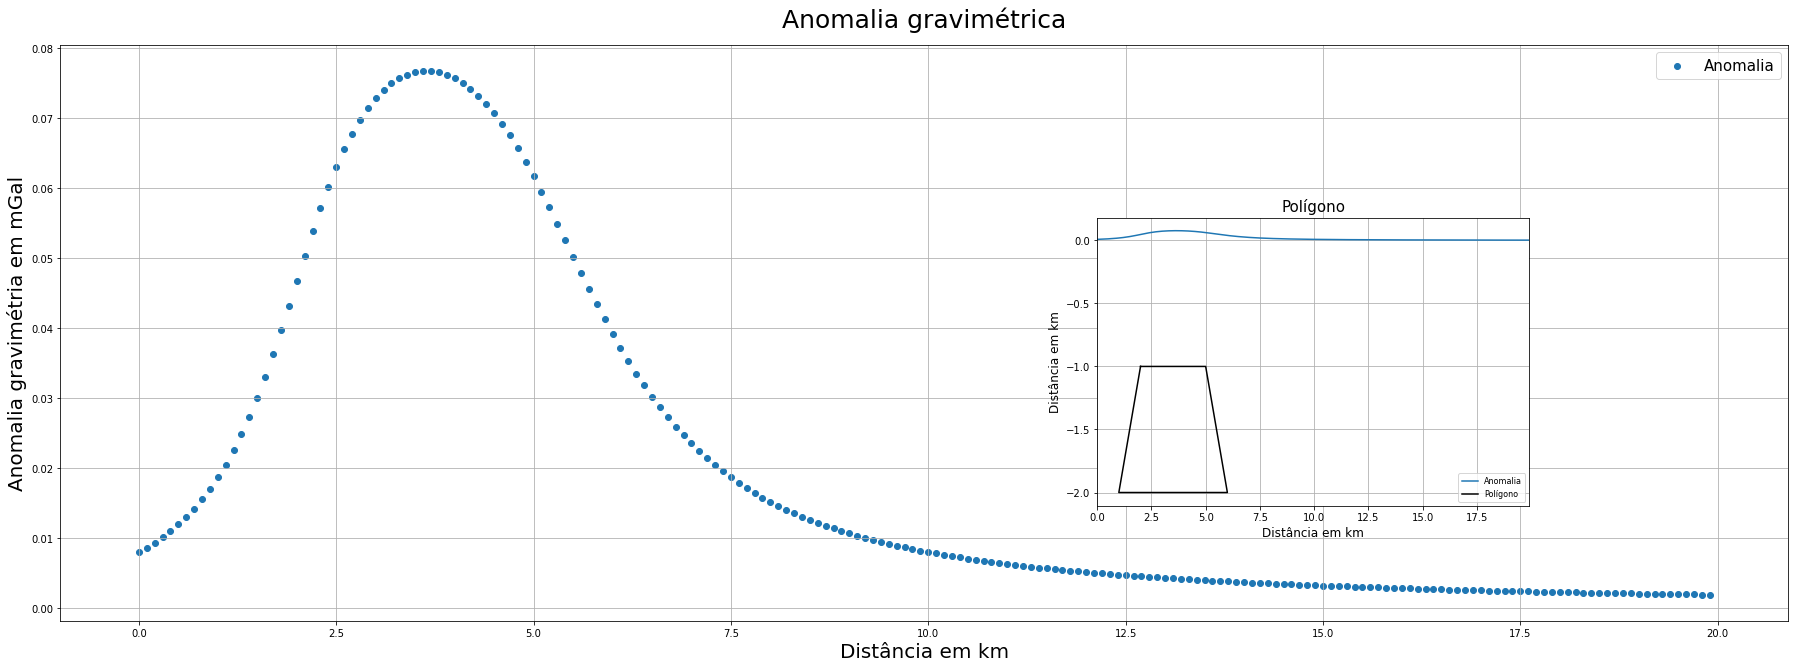

In [ ]:
p1 = [2, -1]
p2 = [5, -1]
p3 = [6, -2]
p4 = [1, -2]
pontos = [p1, p2, p3, p4]
arranjo_1 = arranjo(100, 20, 0.1)
poly_1 = criar_poligono_array(pontos)
cal_1 = calculo_gravimetrico(arranjo_1, poly_1)
plot_grafico(arranjo_1, poly_1, cal_1)

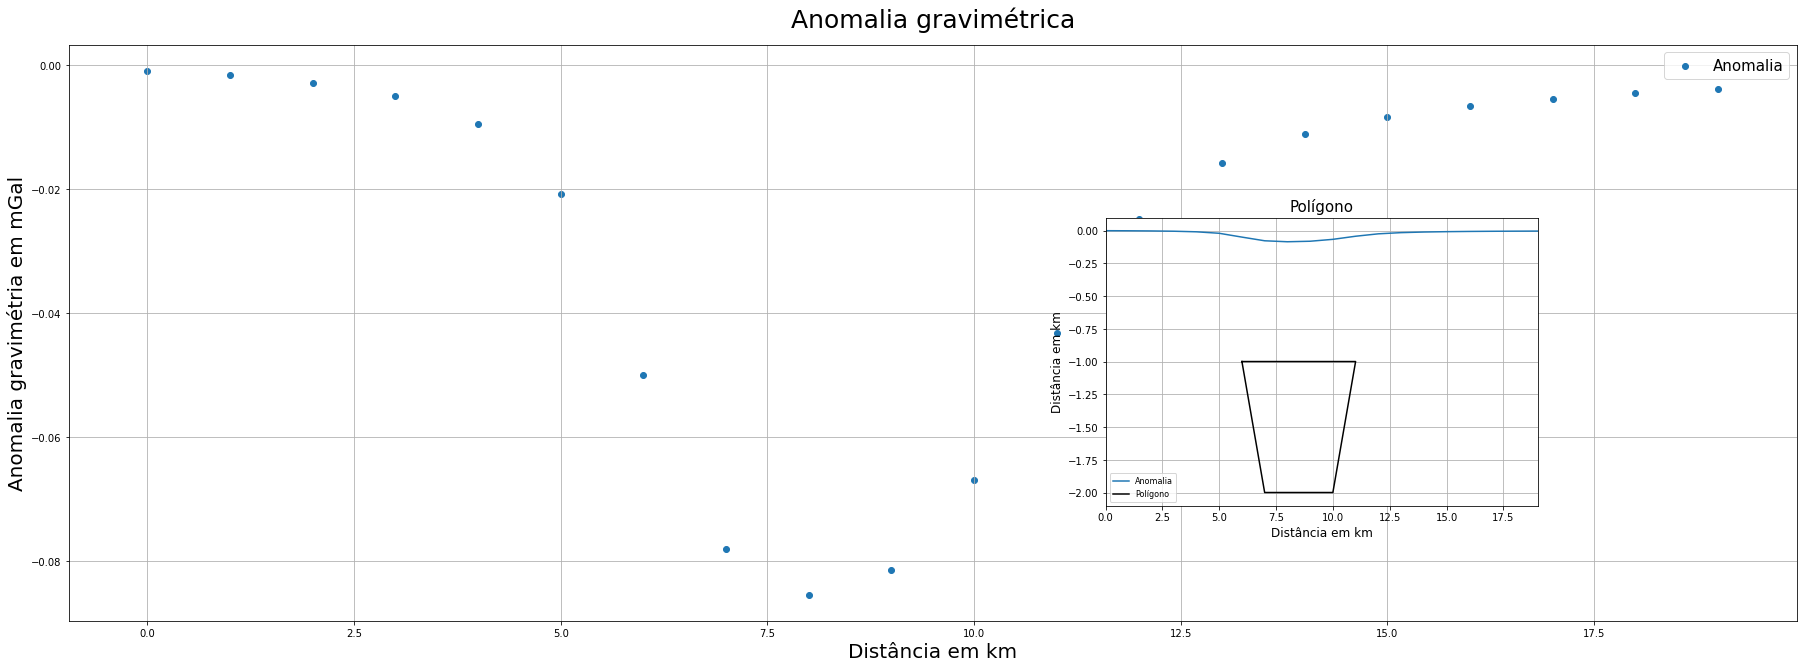

In [ ]:
p1 = [6, -1]
p2 = [11, -1]
p3 = [10, -2]
p4 = [7, -2]
pontos1 = [p1, p2, p3, p4]
arranjo_2 = arranjo(-100, 20, 1)
poly_2 = criar_poligono_array(pontos1)
cal_2 = calculo_gravimetrico(arranjo_2, poly_2)
plot_grafico(arranjo_2, poly_2, cal_2)